In [32]:
def data_in_bit(inputs):
    res = []
    for i in inputs:
        temp = []
        for j in i:
            binary = format(j,'b').zfill(4)
            binary = reverse_str(binary)
            temp.append(binary)
        res.append(temp)
    return np.array(res)
def reverse_str(str_):
    res = ''
    for i in range(len(str_)):
        res = res + str_[-i-1]
    return res

In [33]:
from qiskit import *
import numpy as np
from qiskit.circuit.library import MCXGate
from qiskit.primitives import *
import numpy as np
import matplotlib.pyplot as plt
X_Y_num = 4

X_index = QuantumRegister(X_Y_num,name='X_layer')
Y_index = QuantumRegister(X_Y_num,name='Y_layer')
coeffs = QuantumRegister(4,name='coeffs_layer')


def make_qc_layers(quantum_input):
    qc_layers = []
    for z in range(2):
        temp_layer = []
        for m in range(2):
            binary_inputs = data_in_bit(quantum_input[z][m])
            qc = QuantumCircuit(X_index,Y_index,coeffs)

            for i in range(X_Y_num):
                qc.h(X_index[i])
            for i in range(X_Y_num):
                qc.h(Y_index[i])          
            
            for i in range(2**X_Y_num):
                for j in range(2**X_Y_num):
                    X_idx = format(i,'b').zfill(X_Y_num)
                    Y_idx = format(j,'b').zfill(X_Y_num)
                    coeff = binary_inputs[i][j]
                    gate = MCXGate(X_Y_num*2,ctrl_state=X_idx+Y_idx)
                    for index,k in enumerate(coeff):
                        if k == '1':
                            qc.append(gate,X_index[:]+Y_index[:]+[coeffs[index]])
                            
                            
            for i in range(X_Y_num-1):
                qc.crx(np.pi/2,X_index[0],X_index[i+1])
            for i in range(X_Y_num-1):
                qc.crx(np.pi/2,X_index[0],Y_index[i+1])
                
            for i in range(X_Y_num-1):
                qc.crx(np.pi/2,Y_index[0],X_index[i+1])
            for i in range(X_Y_num-1):
                qc.crx(np.pi/2,Y_index[0],Y_index[i+1])
                
            for i in range(1,X_Y_num-1):
                qc.crx(np.pi/2,X_index[1],X_index[i+1])
            for i in range(1,X_Y_num-1):
                qc.crx(np.pi/2,X_index[1],Y_index[i+1])
                
            for i in range(2,X_Y_num-1):
                qc.crx(np.pi/2,Y_index[2],X_index[i+1])
            for i in range(2,X_Y_num-1):
                qc.crx(np.pi/2,Y_index[2],Y_index[i+1])
            
            for i in range(2,X_Y_num-1):
                qc.crx(np.pi/2,Y_index[2],X_index[i+1])
            for i in range(2,X_Y_num-1):
                qc.crx(np.pi/2,Y_index[2],Y_index[i+1])
                            
            qc.measure_all()
            
            
            temp_layer.append(qc)
        qc_layers.append(temp_layer)
    return qc_layers

In [113]:
X_Y_num = 2

X_index = QuantumRegister(X_Y_num,name='X_layer')
Y_index = QuantumRegister(X_Y_num,name='Y_layer')
coeffs = QuantumRegister(4,name='coeffs_layer')


def pooling_decoder(qc_layers):
    all_result = []

    for z in range(8):
        temp_result = []
        for m in range(8):
            
            sampler = Sampler()
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}
            for i in result.keys():
                binary_dict[format(i,'b').zfill(6)] = result[i]  
            decoded_result = []
            
            for i in range(2):
                temp = []
                for j in range(2):
                    X_idx = format(i,'b').zfill(1)
                    Y_idx = format(j,'b').zfill(1)
                    key = X_idx+Y_idx
                    value_list = []
                    prob_list = []
                    for k in binary_dict.keys():
                        if k[4:] == key:
                            value_list.append(int(k[:4],2))
                            prob_list.append(binary_dict[k])
                    res = 0
                    
                    for value in range(len(value_list)):
                        res = res + value_list[value]*prob_list[value]
                    temp.append(res)
                        
                            
                
            decoded_result.append(int(np.max(temp)*np.pi*2))        
            temp_result.append(decoded_result)
        all_result.append(temp_result)
    all_result = np.array(all_result)

    final_res = all_result.reshape(-1)
    return final_res

In [161]:
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RZZGate
from qiskit.circuit.library import RZZGate
from qiskit.circuit.library import RXXGate

Cbits = ClassicalRegister(6)

def make_qc_layers_CNN(quantum_input,theta):
    theta_index = 0
    qc_layers = []
    for z in range(8):
        temp_layer = []
        for m in range(8):
            Theta_list = ParameterVector('theta'+str(z)+str(m),4)
            binary_inputs = data_in_bit(quantum_input[z][m])
            qc = QuantumCircuit(X_index,Y_index,coeffs,Cbits)

            for i in range(X_Y_num):
                qc.h(X_index[i])
            for i in range(X_Y_num):
                qc.h(Y_index[i])          
            
            for i in range(2**X_Y_num):
                for j in range(2**X_Y_num):
                    X_idx = format(i,'b').zfill(X_Y_num)
                    Y_idx = format(j,'b').zfill(X_Y_num)
                    coeff = binary_inputs[i][j]
                    gate = MCXGate(X_Y_num*2,ctrl_state=X_idx+Y_idx)
                    for index,k in enumerate(coeff):
                        if k == '1':
                            qc.append(gate,X_index[:]+Y_index[:]+[coeffs[index]])
                            
            for i in range(4):
                qc.rx(Theta_list[0],i)
                qc.rz(Theta_list[0],i)
        
            ## dense layer
            qc.append(RZZGate(Theta_list[1]),[0,1])
            qc.append(RZZGate(Theta_list[1]),[2,3])
            qc.append(RZZGate(Theta_list[1]),[1,2])
            qc.append(RXXGate(Theta_list[1]),[0,1])
            qc.append(RXXGate(Theta_list[1]),[2,3])
            qc.append(RXXGate(Theta_list[1]),[1,2])
            
            for i in range(4):
                qc.rx(Theta_list[2],i)
                qc.rz(Theta_list[2],i)
        
            ## dense layer
            qc.append(RZZGate(Theta_list[3]),[0,1])
            qc.append(RZZGate(Theta_list[3]),[2,3])
            qc.append(RZZGate(Theta_list[3]),[1,2])
            qc.append(RXXGate(Theta_list[3]),[0,1])
            qc.append(RXXGate(Theta_list[3]),[2,3])
            qc.append(RXXGate(Theta_list[3]),[1,2])
                
                
                            
            qc.measure([X_index[-1]]+[Y_index[-1]]+[coeffs[0]]+[coeffs[1]]+[coeffs[2]]+[coeffs[3]],[i for i in range(6)])            
            for i in range(4):
                qc= qc.bind_parameters({Theta_list[i]:theta[i]})
            temp_layer.append(qc)
        qc_layers.append(temp_layer)
    return qc_layers

In [162]:
from qiskit.circuit import ParameterVector
Cbits = ClassicalRegister(6)

def make_qc_layers_CNN_8(quantum_input,theta):
    theta_index = 0
    qc_layers = []
    for z in range(2):
        temp_layer = []
        for m in range(2):
            Theta_list = ParameterVector('theta'+str(z)+str(m),4)
            binary_inputs = data_in_bit(quantum_input[z][m])
            qc = QuantumCircuit(X_index,Y_index,coeffs,Cbits)

            for i in range(X_Y_num):
                qc.h(X_index[i])
            for i in range(X_Y_num):
                qc.h(Y_index[i])          
            
            for i in range(2**X_Y_num):
                for j in range(2**X_Y_num):
                    X_idx = format(i,'b').zfill(X_Y_num)
                    Y_idx = format(j,'b').zfill(X_Y_num)
                    coeff = binary_inputs[i][j]
                    if len(coeff)>4:
                        coeff = '1111'
            
                    gate = MCXGate(X_Y_num*2,ctrl_state=X_idx+Y_idx)
                    for index,k in enumerate(coeff):
                        if k == '1':
                            qc.append(gate,X_index[:]+Y_index[:]+[coeffs[index]])
                            
                
            for i in range(4):
                qc.rx(Theta_list[0],i)
                qc.rz(Theta_list[0],i)
        
            ## dense layer
            qc.append(RZZGate(Theta_list[1]),[0,1])
            qc.append(RZZGate(Theta_list[1]),[2,3])
            qc.append(RZZGate(Theta_list[1]),[1,2])
            qc.append(RXXGate(Theta_list[1]),[0,1])
            qc.append(RXXGate(Theta_list[1]),[2,3])
            qc.append(RXXGate(Theta_list[1]),[1,2])
            
            for i in range(4):
                qc.rx(Theta_list[2],i)
                qc.rz(Theta_list[2],i)
        
            ## dense layer
            qc.append(RZZGate(Theta_list[3]),[0,1])
            qc.append(RZZGate(Theta_list[3]),[2,3])
            qc.append(RZZGate(Theta_list[3]),[1,2])
            qc.append(RXXGate(Theta_list[3]),[0,1])
            qc.append(RXXGate(Theta_list[3]),[2,3])
            qc.append(RXXGate(Theta_list[3]),[1,2])
                
                            
            qc.measure([X_index[-1]]+[Y_index[-1]]+[coeffs[0]]+[coeffs[1]]+[coeffs[2]]+[coeffs[3]],[i for i in range(6)])            
            for i in range(4):
                qc= qc.bind_parameters({Theta_list[i]:theta[i]})
            temp_layer.append(qc)
        qc_layers.append(temp_layer)
    return qc_layers

In [111]:
X_Y_num = 2

X_index = QuantumRegister(X_Y_num,name='X_layer')
Y_index = QuantumRegister(X_Y_num,name='Y_layer')
coeffs = QuantumRegister(4,name='coeffs_layer')


def pooling_decoder_8(qc_layers):
    all_result = []

    for z in range(2):
        for m in range(2):
            
            sampler = Sampler()
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}
            for i in result.keys():
                binary_dict[format(i,'b').zfill(6)] = result[i]  
            for i in range(2):
                temp = []
                for j in range(2):
                    X_idx = format(i,'b').zfill(1)
                    Y_idx = format(j,'b').zfill(1)
                    key = X_idx+Y_idx
                    value_list = []
                    prob_list = []
                    for k in binary_dict.keys():
                        if k[4:] == key:
                            value_list.append(int(k[:4],2))
                            prob_list.append(binary_dict[k])
                    res = 0
                    
                    for value in range(len(value_list)):
                        res = res + value_list[value]*prob_list[value]
                    temp.append(res)
                        
                            
                
            all_result.append(np.max(temp))
    all_result = np.array(all_result)

    final_res = all_result.reshape(-1)
    return final_res

In [177]:
from qiskit.circuit.library import RZZGate
from qiskit.circuit.library import RXXGate
result_list = []
def Quantum_layer(parameters,qc_set,label):
    result_set = []
    qc_layers_list = []
    parameter_index = 0
    for image in qc_set:
        result_CNN_list = []
        for i in range(2):
            qc_layers_list.append(make_qc_layers_CNN(image,parameters[4*i:4*(i+1)]))
        for i in range(2):
            result_CNN_list.append(pooling_decoder(qc_layers_list[i]))
        result_set.append(result_CNN_list)
    parameter_index+=8       
        
    qc_set_8 = []
    for channel in result_set:
        for image in channel:
            quantum_input = image.reshape(2,2,2**X_Y_num,2**X_Y_num)
            qc_set_8.append(quantum_input)
                
    hidden_set = []   
    for image in qc_set_8:
        qc_layers1 = make_qc_layers_CNN_8(image,parameters[parameter_index:parameter_index+4])
        result_value1 = pooling_decoder_8(qc_layers1)
        hidden_set.append(result_value1)
    result_list = []
    parameter_index+=4
    hidden_set = np.array(hidden_set).reshape(-1,8)
    
    
    for hidden in hidden_set:
    
        ## Quantum network
        qc = QuantumCircuit(8,1)
        ## Angle embedding
        for i in range(8):
            qc.ry(hidden[i],i)
        
        ## dense layer
        for i in range(4):
            qc.append(RZZGate(parameters[parameter_index]),[2*i,2*i+1])
            qc.append(RXXGate(parameters[parameter_index]),[2*i,2*i+1])
        for i in range(3):
            qc.append(RZZGate(parameters[parameter_index]),[2*i+1,2*i+3])
            qc.append(RXXGate(parameters[parameter_index]),[2*i+1,2*i+3])
 
        
        for i in range(8):
            qc.rx(parameters[parameter_index+1],i)
            qc.rz(parameters[parameter_index+1],i)

        
        ## dense layer
        for i in range(4):
            qc.append(RZZGate(parameters[parameter_index+2]),[2*i,2*i+1])
            qc.append(RXXGate(parameters[parameter_index+2]),[2*i,2*i+1])
        for i in range(3):
            qc.append(RZZGate(parameters[parameter_index+2]),[2*i+1,2*i+2])
            qc.append(RXXGate(parameters[parameter_index+2]),[2*i+1,2*i+2])
 
        
        for i in range(8):
            qc.rx(parameters[parameter_index+3]+3,i)
            qc.rz(parameters[parameter_index+3],i)
        
        ## dense layer
        for i in range(4):
            qc.append(RZZGate(parameters[parameter_index+4]),[2*i,2*i+1])
            qc.append(RXXGate(parameters[parameter_index+4]),[2*i,2*i+1])
        for i in range(3):
            qc.append(RZZGate(parameters[parameter_index+4]),[2*i+1,2*i+2])
            qc.append(RXXGate(parameters[parameter_index+4]),[2*i+1,2*i+2])
            

        
        for i in range(8):
            qc.rx(parameters[parameter_index+5],i)
            qc.rz(parameters[parameter_index+5],i)
            
        
        qc.measure(7,0)
        sampler = Sampler()
        result = sampler.run(qc).result().quasi_dists[0]                
        result_list.append(result[0])
    
    res = 0     
    for index, i in enumerate(result_list):
        res += -(label[index]*np.log(i+0.000000001)+(1-label[index])*np.log(1-i+0.00000001))/len(label)
    acc = 0
    for index, i in enumerate(result_list):
        if round(i,0) == label[index]:
            acc+=1/len(label) 
            
        
    print('result : ',res)
    print('Acc : ',acc)
    result_list.append(res)
    return res
        
    

In [178]:
full_labels = np.load('./data/labels_test_100.npy')
full_image = np.load('./data/images_test_100.npy')

label = np.array(full_labels,dtype=int)
test_set = full_image[:50]

qc_set = []
for i in test_set:
    quantum_input = np.pad(i,((0,4),(0,4)))
    quantum_input = np.array(quantum_input/16,dtype=int)
    quantum_input = quantum_input.reshape(8,8,2**X_Y_num,2**X_Y_num)
    qc_set.append(quantum_input)

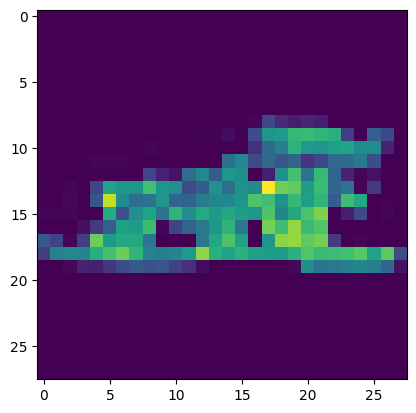

In [179]:
plt.imshow(full_image[1])

In [184]:
for i in range(5):
    parameters = list(np.random.random(18)*np.pi/2)
    print(Quantum_layer(parameters,qc_set[3:4],label[3:4]))

/tmp/ipykernel_240933/2509753800.py:61: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc= qc.bind_parameters({Theta_list[i]:theta[i]})
/tmp/ipykernel_240933/2180618354.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc= qc.bind_parameters({Theta_list[i]:theta[i]})


result :  1.3350834964850797
Acc :  0
1.3350834964850797
result :  0.653022741211546
Acc :  1.0
0.653022741211546
result :  0.08633042602608883
Acc :  1.0
0.08633042602608883
result :  0.8662312929206254
Acc :  0
0.8662312929206254
result :  1.3092111750054023
Acc :  0
1.3092111750054023


In [189]:
# callback 
init = np.random.random(18)
iter = [1]
parameters = []

def optimization_callback(x):
    print(f"Iteration: {iter[0]}")
    parameters.append(x)
    temp = np.array(parameters)
    temp1 = np.array(result_list)
    np.save('parameters.npy',temp)
    np.save('result.npy',temp1)
    iter[0] += 1


from scipy.optimize import minimize

result = minimize(Quantum_layer,init,args=(qc_set[:50],label[:50]),callback=optimization_callback,method='COBYLA')

/tmp/ipykernel_240933/2509753800.py:61: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc= qc.bind_parameters({Theta_list[i]:theta[i]})
/tmp/ipykernel_240933/2180618354.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc= qc.bind_parameters({Theta_list[i]:theta[i]})


result :  0.7285623155085038
Acc :  0.4000000000000001
Iteration: 1
result :  0.73145445548151
Acc :  0.4000000000000001
Iteration: 2
result :  0.7323174872689024
Acc :  0.4000000000000001
Iteration: 3
result :  0.7287174315785149
Acc :  0.4000000000000001
Iteration: 4
result :  0.7318024453908141
Acc :  0.4000000000000001
Iteration: 5
result :  0.7102562895381104
Acc :  0.4000000000000001
Iteration: 6
result :  0.7798338050085745
Acc :  0.4000000000000001
Iteration: 7
